In [1]:
from glob import glob
import pandas as pd
from pathlib import Path
import sys
from itertools import combinations, product
sys.path.append('../')

import matplotlib.pyplot as plt
from tqdm import tqdm
from astropy.table import unique, join
import papermill as pm


In [2]:
from uvot import filters
from xrt import curves
from source_names_dict import source_names_dict, source_names_w_counterparts, source_names_readable
from get_closest_srcreg import get_src_region_dict
from uvot import read_uvotsource, calc_uvot_flags, filters, filter_colors, filter_markers
from xrt import load_xrt, rename_xrt_cols, curves
from lightcurve import LightCurve

In [3]:
all_df = []
for f in tqdm(glob('../lightcurves/correlation_output/*/tables/*table_prop*')):
    sp = f.split('/')[-1].split(',')
    simbad_name = sp[0]
    xrt_curve   = sp[1]
    uvot_filter = sp[2]
    include_bad = sp[3]
    include_UL  = sp[4]
    
    df = pd.read_csv(f)
    df['simbad_name'] = simbad_name
    df['xrt_curve'] = xrt_curve
    df['uvot_filter'] = uvot_filter
    df['include_bad'] = include_bad
    df['include_UL']  = include_UL
    
    all_df.append(df)
df_prop = pd.concat(all_df)
df_prop


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1019/1019 [00:06<00:00, 156.26it/s]


,name,length,N_obs,N_bad,N_good,N_UL,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL
0,tab,166,101,0,166,2,Holmberg_II_X-1,FULL,U,False,False
1,tab_5_sig,166,101,0,166,2,Holmberg_II_X-1,FULL,U,False,False
2,tab_UL,2,2,0,2,2,Holmberg_II_X-1,FULL,U,False,False
3,tab_no_UL,164,99,0,164,0,Holmberg_II_X-1,FULL,U,False,False
4,tab_BAD,0,0,0,0,0,Holmberg_II_X-1,FULL,U,False,False
...,...,...,...,...,...,...,...,...,...,...,...
3,tab_no_UL,41,36,1,40,0,[SRW2006b]_NGC_55_ULX,SOFT,UVW2,True,False
4,tab_BAD,1,1,1,0,0,[SRW2006b]_NGC_55_ULX,SOFT,UVW2,True,False
5,tab_no_BAD,40,35,0,40,0,[SRW2006b]_NGC_55_ULX,SOFT,UVW2,True,False
6,tab_UL_no_bad,0,0,0,0,0,[SRW2006b]_NGC_55_ULX,SOFT,UVW2,True,False


In [4]:
all_res = []
for f in tqdm(glob('../lightcurves/correlation_output/*/tables/*table_corr*')):
    sp = f.split('/')[-1].split(',')
    simbad_name = sp[0]
    xrt_curve = sp[1]
    uvot_filter = sp[2]
    include_bad = sp[3]
    include_UL  = sp[4]
    
    # print(simbad_name, xrt_curve, uvot_filter)
    
    df = pd.read_csv(f)
    r_mean = df['r'].mean()
    r_std  = df['r'].std()
    m_mean = df['m'].mean()
    m_std  = df['m'].std()
    c_mean = df['c'].mean()
    c_std  = df['c'].std()
    
    res = {}
    res['simbad_name'] = simbad_name
    res['xrt_curve'] = xrt_curve
    res['uvot_filter'] = uvot_filter
    res['include_bad'] = include_bad
    res['include_UL'] = include_UL
    
    res['r_mean'] = r_mean
    res['r_std'] = r_std
    res['m_mean'] = m_mean
    res['m_std'] = m_std
    res['c_mean'] = c_mean
    res['c_std'] = c_std
    
    all_res.append(res)
df = pd.DataFrame(all_res)
df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1019/1019 [00:12<00:00, 81.27it/s]


,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL,r_mean,r_std,m_mean,m_std,c_mean,c_std
0,Holmberg_II_X-1,FULL,U,False,False,0.060790,0.035143,0.262742,0.152084,4.581733,0.025354
1,Holmberg_II_X-1,FULL,U,False,True,0.223747,0.050548,1.445039,0.531554,4.362411,0.097665
2,Holmberg_II_X-1,FULL,U,True,False,0.060671,0.035561,0.262324,0.153964,4.581791,0.025517
3,Holmberg_II_X-1,FULL,U,True,True,0.224846,0.049680,1.456770,0.530538,4.360249,0.097472
4,Holmberg_II_X-1,FULL,UVM2,False,False,-0.028258,0.078480,-0.114649,0.305283,2.070258,0.060918
...,...,...,...,...,...,...,...,...,...,...,...
1014,[SRW2006b]_NGC_55_ULX,SOFT,UVM2,True,False,0.088633,0.150098,0.286430,0.488772,0.295750,0.020857
1015,[SRW2006b]_NGC_55_ULX,SOFT,UVW1,False,False,-0.025397,0.083256,-0.152800,0.513456,0.597235,0.024708
1016,[SRW2006b]_NGC_55_ULX,SOFT,UVW1,True,False,-0.019086,0.081635,-0.108179,0.475556,0.594623,0.022619
1017,[SRW2006b]_NGC_55_ULX,SOFT,UVW2,False,False,-0.166631,0.106321,-0.534569,0.349669,0.490887,0.016000


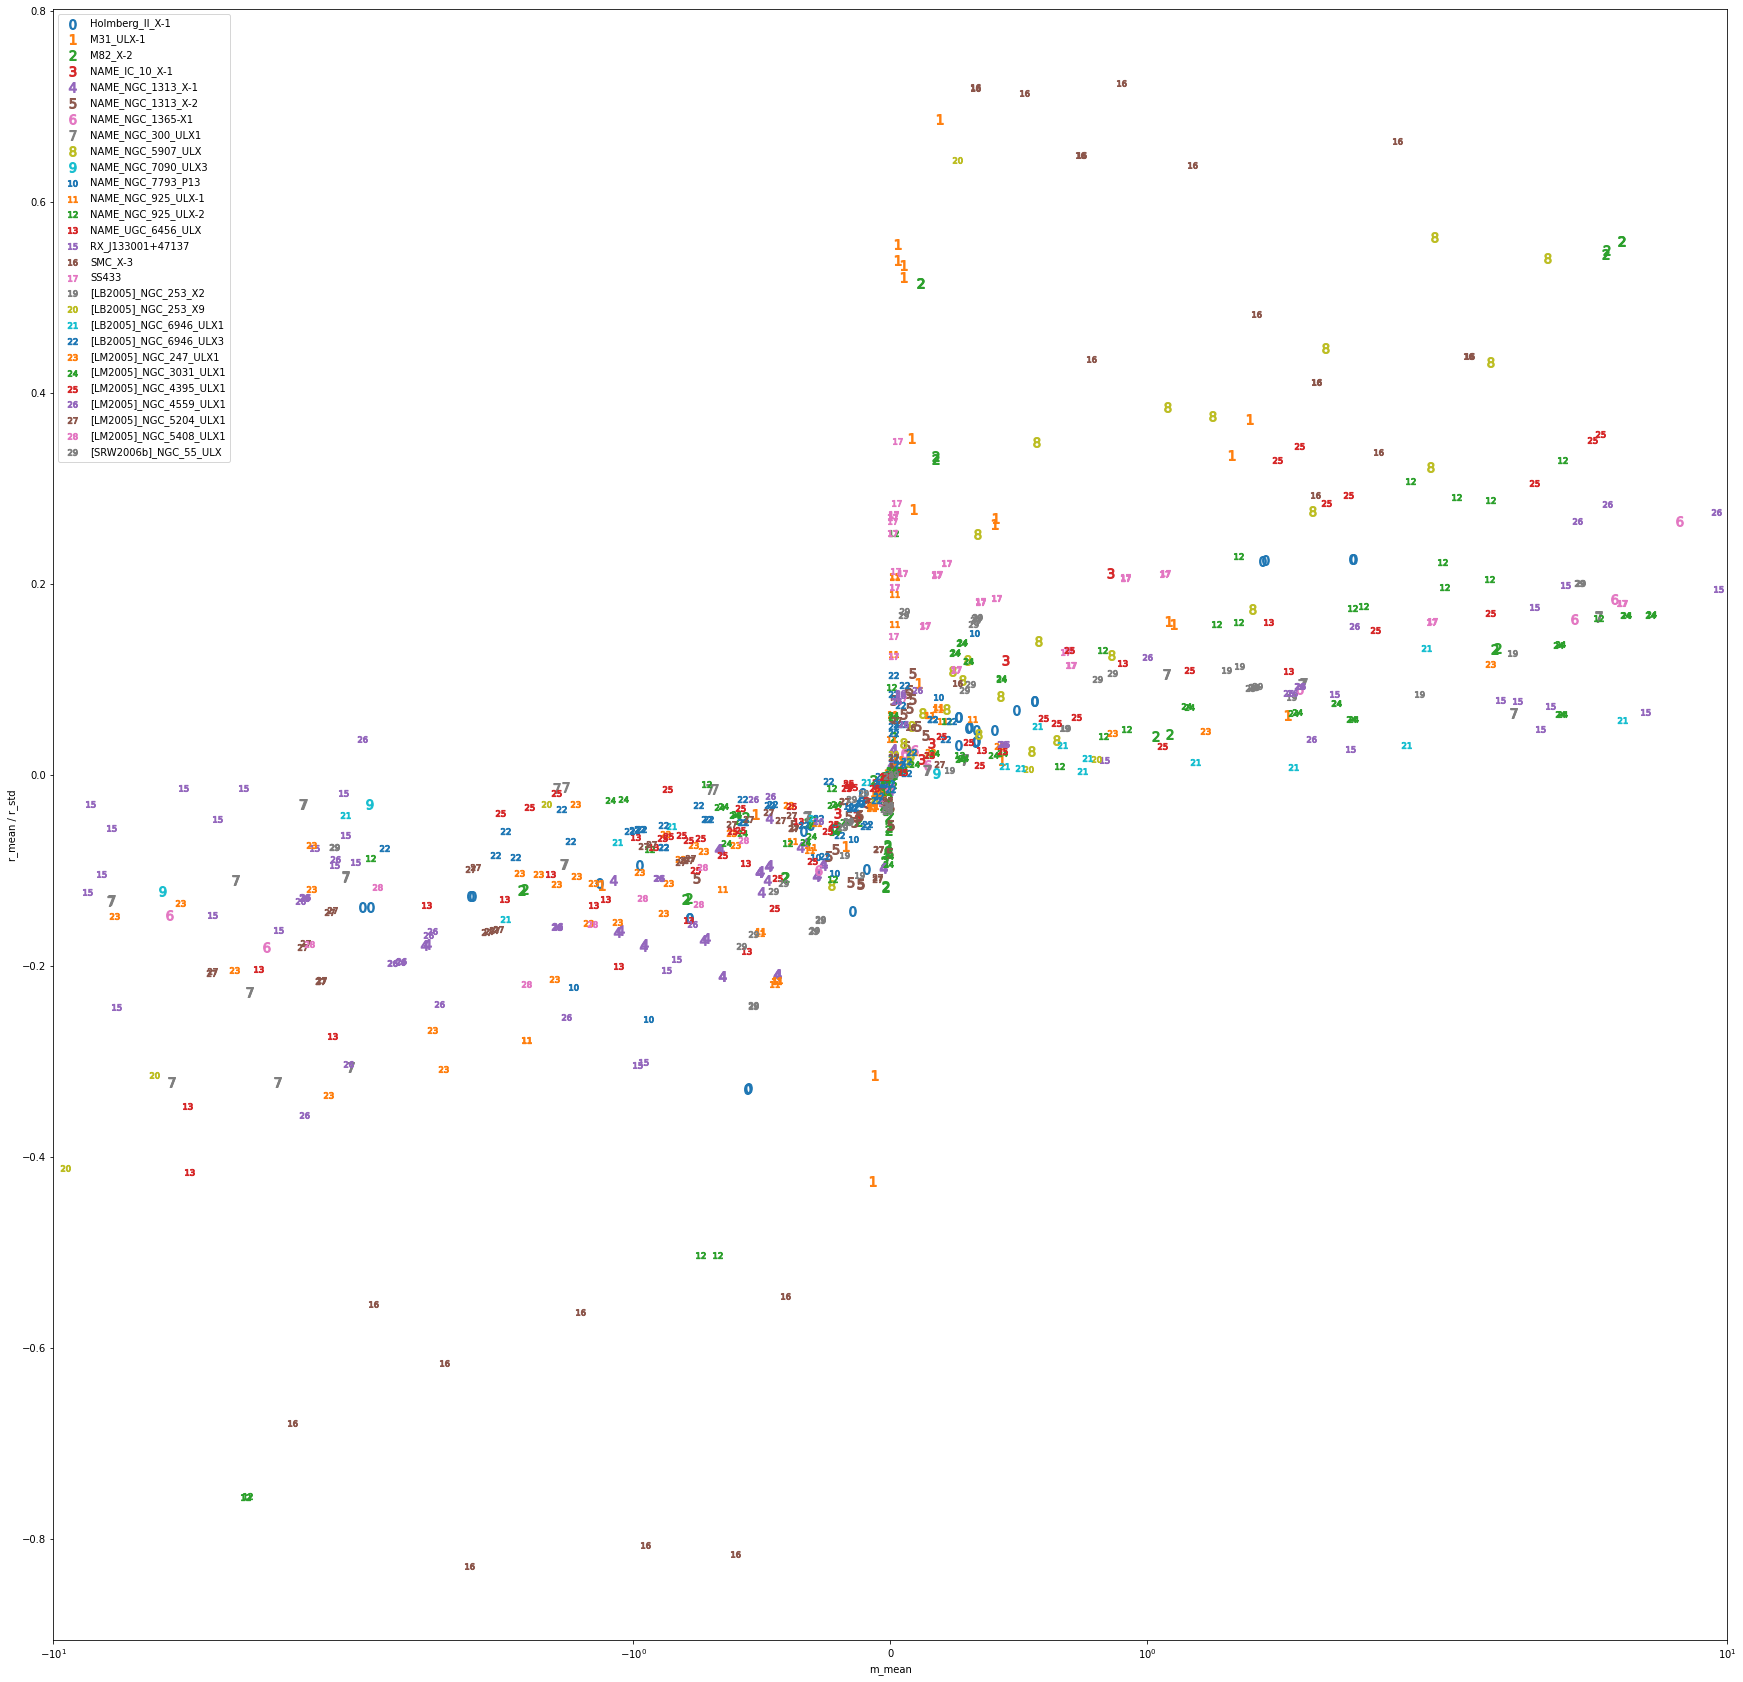

In [27]:
exclude = ['SWIFT_J0243.6+6124', 'NOVA_Cyg_1989']

nsig     = 2
r_mu     = df['r_mean'].mean()
r_std    = df['r_mean'].std()
r_sig_up = r_mu + nsig*r_std
r_sig_lo = r_mu - nsig*r_std


df['nsig'] = abs((df['r_mean'] - r_mu) / r_std)

plt.figure(figsize=(30,30), facecolor='white')
for i, s in enumerate(df['simbad_name'].unique()):
    if s in exclude:
        continue
    sub = df[df['simbad_name'] == s]
    plt.scatter(sub['m_mean'], sub['r_mean'], marker=f'${i}$', label=s, s=100)
    #plt.errorbar(sub['m_mean'], sub['r_mean'], xerr=sub['m_std'], yerr=sub['r_std'], marker=f'${i}$', label=s, markersize=10)
plt.xlabel('m_mean')
plt.ylabel('r_mean / r_std')

plt.xscale('symlog')
#plt.ylim(-5,5)
plt.xlim(-10,10)
plt.legend()
#plt.ylim(-10,10)


In [28]:
sub_nsig = df[(df['r_mean'] > r_sig_up) | (df['r_mean'] < r_sig_lo)]
sub_nsig

,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL,r_mean,r_std,m_mean,m_std,c_mean,c_std,nsig
52,M31_ULX-1,FULL,UVW2,True,False,0.687030,0.230579,0.189701,0.089338,0.106732,0.007050,2.456379
226,NAME_NGC_300_ULX1,FULL,B,False,False,-0.484873,0.026835,-26.661699,2.104958,8.427032,0.146476,2.149274
228,NAME_NGC_300_ULX1,FULL,B,True,False,-0.484714,0.026467,-26.642606,2.071403,8.427117,0.143570,2.148647
246,NAME_NGC_300_ULX1,FULL,V,False,False,-0.497688,0.033453,-12.599503,1.150082,4.267684,0.083618,2.199636
248,NAME_NGC_300_ULX1,FULL,V,True,False,-0.498104,0.033238,-12.619402,1.139924,4.269468,0.084422,2.201271
364,NAME_NGC_925_ULX-2,FULL,U,False,True,-0.755465,0.238954,-3.813000,5.320390,2.190914,0.137041,3.212716
366,NAME_NGC_925_ULX-2,FULL,U,True,True,-0.756465,0.203363,-3.853175,3.751091,2.219646,0.054662,3.216648
376,NAME_NGC_925_ULX-2,FULL,UVW2,False,True,-0.502658,0.161796,-0.674568,0.365471,0.547911,0.018094,2.219168
378,NAME_NGC_925_ULX-2,FULL,UVW2,True,True,-0.503150,0.141356,-0.741761,0.370748,0.572109,0.011259,2.221103
398,NAME_UGC_6456_ULX,FULL,UVM2,False,True,0.592502,0.111916,12.493457,3.734659,0.447319,0.092878,2.084879


In [29]:
pd.join(df, df_prop)

AttributeError: module 'pandas' has no attribute 'join'

In [30]:
df

,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL,r_mean,r_std,m_mean,m_std,c_mean,c_std,nsig
0,Holmberg_II_X-1,FULL,U,False,False,0.060790,0.035143,2.627420e-01,0.152084,4.581733,0.025354,0.004785
1,Holmberg_II_X-1,FULL,U,False,True,0.223747,0.050548,1.445039e+00,0.531554,4.362411,0.097665,0.635647
2,Holmberg_II_X-1,FULL,U,True,False,0.060671,0.035561,2.623238e-01,0.153964,4.581791,0.025517,0.005251
3,Holmberg_II_X-1,FULL,U,True,True,0.224846,0.049680,1.456770e+00,0.530538,4.360249,0.097472,0.639966
4,Holmberg_II_X-1,FULL,UVM2,False,False,-0.028258,0.078480,-1.146493e-01,0.305283,2.070258,0.060918,0.354749
5,Holmberg_II_X-1,FULL,UVM2,False,True,-0.027830,0.077880,-1.126389e-01,0.303614,2.070021,0.060551,0.353066
6,Holmberg_II_X-1,FULL,UVM2,True,False,-0.056766,0.084712,-2.175415e-01,0.323179,2.095668,0.065342,0.466787
7,Holmberg_II_X-1,FULL,UVM2,True,True,-0.057087,0.084987,-2.185178e-01,0.324016,2.095563,0.065438,0.468049
8,Holmberg_II_X-1,FULL,UVW1,False,False,-0.150041,0.038492,-7.847505e-01,0.203643,3.213436,0.030513,0.833363
9,Holmberg_II_X-1,FULL,UVW1,False,True,0.225522,0.049203,1.800023e+00,0.564699,2.742473,0.099631,0.642625


In [31]:
df_prop_tab_5_sig = df_prop[df_prop['name'] == 'tab_5_sig']

In [32]:
pd.set_option('display.max_rows', None)

In [33]:
pd.merge(sub_nsig, df_prop_tab_5_sig, on=['simbad_name','xrt_curve','uvot_filter','include_bad','include_UL'])

,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL,r_mean,r_std,m_mean,m_std,c_mean,c_std,nsig,name,length,N_obs,N_bad,N_good,N_UL
0,M31_ULX-1,FULL,UVW2,True,False,0.687030,0.230579,0.189701,0.089338,0.106732,0.007050,2.456379,tab_5_sig,93,93,88,5,87
1,NAME_NGC_300_ULX1,FULL,B,False,False,-0.484873,0.026835,-26.661699,2.104958,8.427032,0.146476,2.149274,tab_5_sig,54,48,0,54,31
2,NAME_NGC_300_ULX1,FULL,B,True,False,-0.484714,0.026467,-26.642606,2.071403,8.427117,0.143570,2.148647,tab_5_sig,54,48,0,54,31
3,NAME_NGC_300_ULX1,FULL,V,False,False,-0.497688,0.033453,-12.599503,1.150082,4.267684,0.083618,2.199636,tab_5_sig,49,43,0,49,29
4,NAME_NGC_300_ULX1,FULL,V,True,False,-0.498104,0.033238,-12.619402,1.139924,4.269468,0.084422,2.201271,tab_5_sig,49,43,0,49,29
5,NAME_NGC_925_ULX-2,FULL,U,False,True,-0.755465,0.238954,-3.813000,5.320390,2.190914,0.137041,3.212716,tab_5_sig,21,16,16,5,2
6,NAME_NGC_925_ULX-2,FULL,U,True,True,-0.756465,0.203363,-3.853175,3.751091,2.219646,0.054662,3.216648,tab_5_sig,21,16,16,5,2
7,NAME_NGC_925_ULX-2,FULL,UVW2,False,True,-0.502658,0.161796,-0.674568,0.365471,0.547911,0.018094,2.219168,tab_5_sig,51,41,29,22,8
8,NAME_NGC_925_ULX-2,FULL,UVW2,True,True,-0.503150,0.141356,-0.741761,0.370748,0.572109,0.011259,2.221103,tab_5_sig,51,41,29,22,8
9,NAME_UGC_6456_ULX,FULL,UVM2,False,True,0.592502,0.111916,12.493457,3.734659,0.447319,0.092878,2.084879,tab_5_sig,23,14,14,9,7
